# Import Libraries

In [1]:
import scipy.io as sio
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import shutil, os, json
import torch
from torch.utils.data import Dataset
from scipy import ndimage
from sklearn.model_selection import train_test_split
import torchvision
import skimage

# Utility Functions

In [2]:
def resize_volume(img, ex=64):
    current_depth = img.shape[0]
    current_width = img.shape[1]            

    depth_factor = ex / current_depth
    width_factor = ex / current_width

    factors = (depth_factor, width_factor)

    return ndimage.zoom(img, factors, order=1)

def std_img(tens):
    t_ = (tens-tens.min())/(tens.max()-tens.min())
    return t_

# Dataloader

In [3]:
''' 
DATALOADER FOR MODEL: USE FOR TRAINING OR TESTING WITH LARGE DATASETS, PROVIDED A PRE-PROCESSED JSON FILE IS AVAILABLE
'''

# class DataLoading(Dataset):
#     def __init__(self, raw, lge, cine, cine_whole):
#         self.raw= raw
#         self.lge= lge
#         self.cine= cine
#         self.cine_whole = cine_whole
#         self.img_size= 128
        
#     def __len__(self):
#         return len(self.raw)

#     def __getitem__(self, idx):
#         # print(self.raw[idx].shape)
#         image= torch.from_numpy(resize_volume(self.raw[idx],  self.img_size))
#         seg= torch.from_numpy(resize_volume(np.nan_to_num(self.lge[idx], copy=False, nan=0.0),  self.img_size))
#         cine_= torch.from_numpy(resize_volume(self.cine[idx],  self.img_size))
#         cine_whole_= torch.from_numpy(self.cine_whole[idx])
        
#         # return std_img(image.float()).unsqueeze(0), std_img(seg.float()).unsqueeze(0)
#         return std_img(image.float()).unsqueeze(0), std_img(seg.float()).unsqueeze(0), std_img(cine_.float()).unsqueeze(0), std_img(cine_whole_.float()).unsqueeze(0)
    
# def get_data(test_flag=False, batch_size=2):
#     all_data = json.load(open('./dataset/myo_cropped_all_data/split_data_combined_JS1.json'))
#     raw_train = np.array(all_data['x_train']) ; raw_test = np.array(all_data['x_test']) ; lge_train = np.array(all_data['y_train']) ; lge_test = np.array(all_data['y_test'])
#     cine_train = np.array(all_data['cine_train']); cine_test = np.array(all_data['cine_test'])
#     cine_whole_train = np.array(all_data['whole_train']); cine_whole_test= np.array(all_data['whole_test'])

#     if test_flag:
#         ds = DataLoading(raw_test, lge_test, cine_test, cine_whole_test)
#     else:
#         ds = DataLoading(raw_train, lge_train, cine_train, cine_whole_train)
#     datal= torch.utils.data.DataLoader(
#         ds,
#         batch_size=batch_size,
#         shuffle=True)
#     return datal


' \nDATALOADER FOR MODEL: USE FOR TRAINING OR TESTING WITH LARGE DATASETS, PROVIDED A PRE-PROCESSED JSON FILE IS AVAILABLE\n'

# Model Definition

In [4]:
from attention_model import AttentionUNet
from torchmetrics.classification import Dice
DEVICE= 'cuda:0'
# DEVICE= 'cpu'   ### USE IF CPU IS USED FOR INFERENCE INSTEAD OF GPU

In [5]:
model_save_path= 'unet_att_focal_dice350.pt'
# datal= get_data(test_flag=True, batch_size=batch_size)   ### USE FOR TRAINING OR TESTING WITH LARGE DATASETS

inf_data = json.load(open("./inference_sample.json"))

whole_te = torch.tensor(inf_data['lge_whole']).unsqueeze(0).unsqueeze(0)
cine_te = torch.tensor(inf_data['lge_cropped']).unsqueeze(0).unsqueeze(0)
x = torch.tensor(inf_data['masked_input']).unsqueeze(0).unsqueeze(0)
y = torch.tensor(inf_data['lge_seg']).unsqueeze(0).unsqueeze(0)

In [6]:
whole_te.size(), cine_te.size(), x.size(), y.size()

(torch.Size([1, 1, 224, 224]),
 torch.Size([1, 1, 128, 128]),
 torch.Size([1, 1, 128, 128]),
 torch.Size([1, 1, 128, 128]))

In [7]:
model = AttentionUNet(drop_out_prob=0.3).to(DEVICE)
model.load_state_dict(torch.load('./' + model_save_path))
model.eval()

C:\Users\jonathanle\AppData\Local\Temp\ipykernel_29064\3555619029.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./' + model_save_path

AttentionUNet(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    

11.226976
1.0


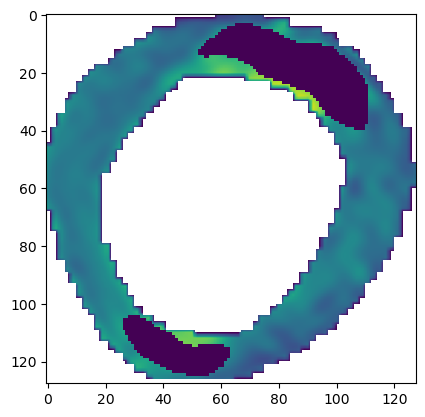

In [31]:
# act= nn.Sigmoid().to(DEVICE)
y_pred= model(x.to(DEVICE))


myo_mask = x.detach().cpu().squeeze().clone().numpy()
myo_mask[myo_mask==0]= np.nan               ### SET TO 0 INSTEAD OF np.nan WHILE EXPORTING MASKS INSTEAD OF VISUALIZING

p1_= y_pred.detach().cpu().squeeze().clone().numpy()
p2_=y_pred.detach().cpu().squeeze().clone().numpy()
p3_=y_pred.detach().cpu().squeeze().clone().numpy()*myo_mask



### GET BINARY MASK USING FIRST VARIABLE
p1_[p1_<0.5]= np.nan                     ### SET TO 0 INSTEAD OF np.nan WHILE EXPORTING MASKS INSTEAD OF VISUALIZING
p1_[p1_>=0.5]=1     
p2_*=myo_mask
preds_mask = p1_*myo_mask

### GET MASKED OUTPUT FOR RAW PROBABILITY VALUES USING SECOND AND THIRD VARIABLE
p3_[p3_<0.5]= np.nan                     ### SET TO 0 INSTEAD OF np.nan WHILE EXPORTING MASKS INSTEAD OF VISUALIZING
# hypothesis - I believe that we set a threshold for a baseline then anything above the baseline
# we assign a probability value

plt.imshow(myo_mask)
plt.imshow(p1_)
print(p1_[20, 100])

C:\Users\jonathanle\AppData\Local\Temp\ipykernel_29064\3497328912.py:65: UserWarning: Adding colorbar to a different Figure <Figure size 2200x250 with 12 Axes> than <Figure size 500x500 with 2 Axes> which fig.colorbar is called on.
  plt.colorbar(overlay, ax=new_ax, shrink=shrink_factor)


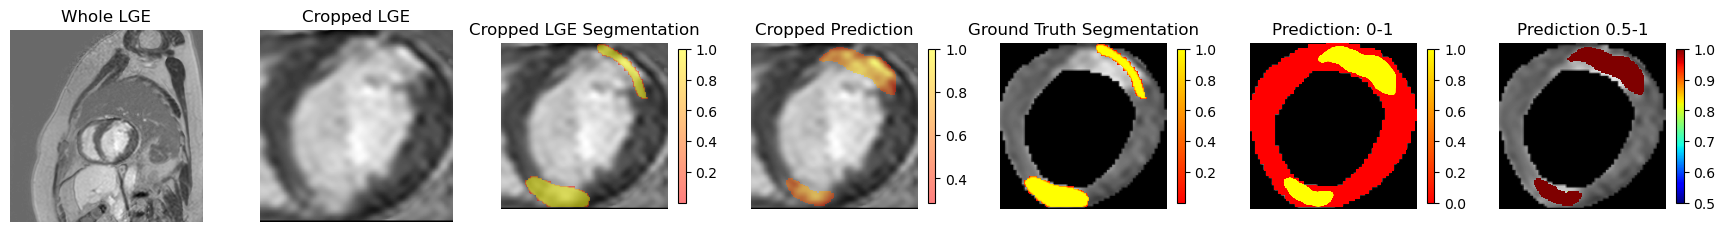

In [24]:
fig, ax = plt.subplots(1,7, figsize=(1.1*5*4, 1*5*0.5))
shrink_factor=0.8
ri=0
ax[ri].imshow(whole_te.squeeze(), cmap='gray')
ax[ri].set_title('Whole LGE')
ax[ri].set_axis_off()
ri+=1

ax[ri].imshow(cine_te.squeeze(), cmap='gray')
ax[ri].set_title('Cropped LGE')
ax[ri].set_axis_off()
ri+=1


ax[ri].imshow(cine_te.squeeze(), cmap='gray')
imi=ax[ri].imshow(y.squeeze(), cmap='autumn', alpha=0.5)
ax[ri].set_title('Cropped LGE Segmentation')
f.colorbar(imi, ax= ax[ri], shrink=shrink_factor)
ax[ri].set_axis_off()
ri+=1

ax[ri].imshow(cine_te.squeeze(), cmap='gray')
imi=ax[ri].imshow(preds_mask.squeeze(), cmap='autumn', alpha=0.5)
ax[ri].set_title('Cropped Prediction')
f.colorbar(imi, ax= ax[ri], shrink=shrink_factor)
ax[ri].set_axis_off()
ri+=1

ax[ri].imshow(x.squeeze(), cmap='gray')
imi=ax[ri].imshow(y.squeeze(), cmap='autumn')
ax[ri].set_title('Ground Truth Segmentation')
f.colorbar(imi, ax= ax[ri], shrink=shrink_factor)
ax[ri].set_axis_off()
ri+=1

ax[ri].imshow(x.squeeze(), cmap='gray')
imi= ax[ri].imshow(p2_.squeeze(), cmap='autumn', vmin= 0, vmax = 1)
f.colorbar(imi, ax= ax[ri], shrink=shrink_factor)
ax[ri].set_title('Prediction: ' + '0-1')
ax[ri].set_axis_off()
ri+=1

ax[ri].imshow(x.squeeze(), cmap='gray')
imi= ax[ri].imshow(p3_.squeeze(), cmap='jet', vmin=0.5, vmax = 1)
f.colorbar(imi, ax= ax[ri], shrink=shrink_factor)
ax[ri].set_title('Prediction 0.5-1')
ax[ri].set_axis_off()

#plt.savefig('./350-mixedL-1.png', dpi=800)


for i, ax_orig in enumerate(ax.flat):
    current_fig = plt.figure(figsize=(5, 5))
    new_ax = current_fig.add_subplot(111)
    
    # Copy base image
    new_ax.imshow(ax_orig.images[0].get_array(), cmap='gray')
    
    # Copy overlay if it exists (for plots with segmentation)
    if len(ax_orig.images) > 1:
        overlay = ax_orig.images[1]
        new_ax.imshow(overlay.get_array(), 
                     cmap=overlay.get_cmap(),
                     alpha=overlay.get_alpha())
        plt.colorbar(overlay, ax=new_ax, shrink=shrink_factor)
    
    # Copy title and axis settings
    new_ax.set_title(ax_orig.get_title())
    new_ax.set_axis_off()
    
    # Save with high resolution
    # current_fig.savefig(f'data/plot_{i}.png', bbox_inches='tight', dpi=800)
    plt.close(current_fig)

In [ ]:
# TODO: 
""" 
Questions - Find Script for preprocesing data from dicom, 


- Does it automatically select slices that are appropriate? above the mitral valve and below the apex? 
- how are we going to processs 

1. Find LGE images from dataset using keywords, bootstrapping PSIR_PSIR (Or mag?)
2. Get Short -Axis --> Extract all the Short Axis using image orientation metadata slice.
3. Get the images that are with mitral + apex.
4. Find a way to get them to crop the images --> cropping
5. then run through the model.


Preprocesssing - use image orientation - to determine if they are short axis slices - 
# if we see this as a heuristical choice, consider just taking 3 slices in the middle 
and evalulating from that to create the images.



- Do i have to crop the image? no - how to preprocess image? 
- MAG vs standard PSIR series? --> use PSIR 
- validate the dataset later - 



- scoring - network later.

df --. 
- Network model - how do I handle patient slices that have 



"""